# Лабораторная работа №4 (Проведение исследований со случайным лесом)

## 2. Создание бейзлайна и оценка качества

#### a.	Обучить модели из sklearn (классификации и регрессии случайным лесом) для выбранных наборов данных

Нужные библиотеки:

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.spatial import distance
from collections import Counter

#### Работа с данными

In [2]:
wine_data = pd.read_csv('../data/wine_data.csv')

wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)

imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)

y_class = wine_data["IsGood"]
y_reg = wine_data["quality"]

x_train, x_test, y_train_class, y_test_class = train_test_split(x_data, y_class, test_size=0.2, random_state=42)
x_train, x_test, y_train_reg, y_test_reg = train_test_split(x_data, y_reg, test_size=0.2, random_state=42)


Для упрощения работы создадим универсальные функции:

In [3]:
def test_model_class(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"LogisticRegression:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1-score: {f1_score(y_test, y_pred)}")
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
        cmap="Greys", annot=True, fmt="d", 
        xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"]
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion matrix")
    plt.show()
    
    return model, y_pred

def test_model_reg(model, X_train,X_test, y_train,  y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"LinearRegression:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test, y_pred)}")
    print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")
    
    return model, y_pred

#### Обучение и оценка моделей

LogisticRegression:
Accuracy: 0.9
F1-score: 0.6


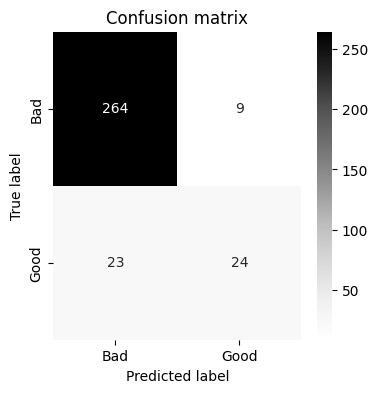

LinearRegression:
Mean Absolute Error (MAE): 0.4224375
Root Mean Squared Error (RMSE): 0.5488516420673258
R-squared (R^2): 0.5390429623873638


In [4]:
_, y_std_pred_class = test_model_class(RandomForestClassifier(random_state=42),
    x_train, x_test, y_train_class, y_test_class
)

_, y_std_pred_reg = test_model_reg(RandomForestRegressor(random_state=42),
    x_train, x_test, y_train_reg, y_test_reg
)


---
## 3. Улучшение бейзлайна

#### a.	Сформулировать гипотезы (препроцессинг данных, визуализация данных, формирование новых признаков, подбор гиперпараметров на кросс-валидации и т.д.)

Проверим 3 гипотезы для увеличения качества оценки качества вина:

1. Масштабирование признаков
2. Формирование новых признаков
3. Подбор гиперпараметров

#### b.	Проверить гипотезы


##### Масштабируем данные

LogisticRegression:
Accuracy: 0.9
F1-score: 0.6


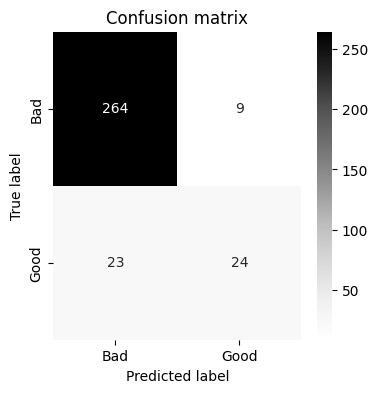

LinearRegression:
Mean Absolute Error (MAE): 0.4219687499999999
Root Mean Squared Error (RMSE): 0.5483250062690921
R-squared (R^2): 0.5399271357910311


In [5]:
scaler_std = StandardScaler()
scaled_x_train = scaler_std.fit_transform(x_train)
scaled_x_test = scaler_std.transform(x_test)

_ = test_model_class(RandomForestClassifier(random_state=42),
    scaled_x_train,scaled_x_test,y_train_class,y_test_class
)

_ = test_model_reg(RandomForestRegressor(random_state=42),
    scaled_x_train,scaled_x_test,y_train_reg,y_test_reg
)

##### Добавление новых признаков, на основе старых данных

LogisticRegression:
Accuracy: 0.909375
F1-score: 0.6329113924050633


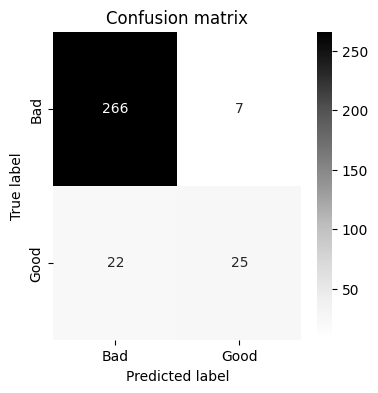

LinearRegression:
Mean Absolute Error (MAE): 0.4211875
Root Mean Squared Error (RMSE): 0.5533279994722841
R-squared (R^2): 0.5314932978675713


In [6]:
x_data_new_features = x_data.copy()

x_data_new_features['bound_so2'] = x_data_new_features['total sulfur dioxide'] - x_data_new_features['free sulfur dioxide']
x_data_new_features['other_acidity'] = x_data_new_features['fixed acidity'] - x_data_new_features['volatile acidity'] - x_data_new_features['citric acid']

_ = test_model_class(RandomForestClassifier(random_state=42),
    *train_test_split(x_data_new_features, y_class, test_size=0.2, random_state=42)
)

_ = test_model_reg(RandomForestRegressor(random_state=42),
    *train_test_split(x_data_new_features, y_reg, test_size=0.2, random_state=42)
)

##### Подбор гиперпараметров

LogisticRegression:
Accuracy: 0.9125
F1-score: 0.65


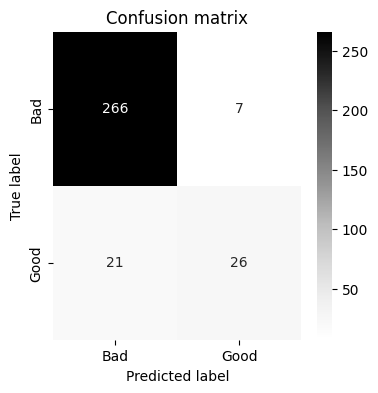

Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}



In [ ]:
grid_params = {
    'max_depth': [5, 10,20, None],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 150],
}

grid_class = GridSearchCV(RandomForestClassifier(random_state=42), grid_params, scoring='accuracy')
grid_class, y_pred_class = test_model_class(grid_class,
    *train_test_split(x_data_new_features, y_class, test_size=0.2, random_state=42)
)
print(f"Best parameters: {grid_class.best_params_}")
print()

grid_reg = GridSearchCV(RandomForestRegressor(random_state=42), grid_params, scoring='r2')
grid_reg, y_pred_reg = test_model_reg(grid_reg,
    *train_test_split(x_data_new_features, y_reg, test_size=0.2, random_state=42)
)
print(f"Best parameters: {grid_reg.best_params_}")
print()

#### c-е.	Сформирован улучшенный бейзлайн по результатам проверки гипотез

Обучить модели с улучшенным бейзлайном (для классификации и регрессии) для выбранных наборов данных
Оценить качество моделей с улучшенным бейзлайном (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

LogisticRegression:
Accuracy: 0.9125
F1-score: 0.65


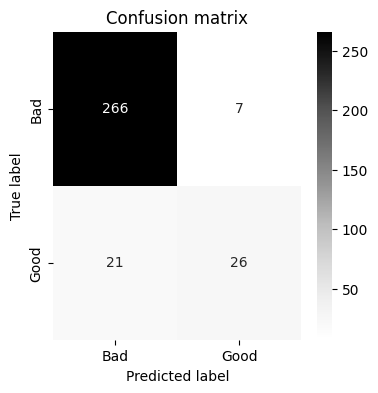

LinearRegression:
Mean Absolute Error (MAE): 0.4222291666666667
Root Mean Squared Error (RMSE): 0.5533793906534648
R-squared (R^2): 0.5314062672783515


In [19]:
wine_data = pd.read_csv('../data/wine_data.csv')
wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)


imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)
x_data_new = x_data.copy()
x_data_new['bound_so2'] = x_data_new['total sulfur dioxide'] - x_data_new['free sulfur dioxide']
x_data_new['other_acidity'] = x_data_new['fixed acidity'] - x_data_new['volatile acidity'] - x_data_new['citric acid']

y_class = wine_data["IsGood"]
y_reg = wine_data["quality"]

x_train, x_test, y_train_class, y_test_class = train_test_split(x_data_new, y_class, test_size=0.2, random_state=42)
x_train, x_test, y_train_reg, y_test_reg = train_test_split(x_data_new, y_reg, test_size=0.2, random_state=42)

_, y_baseline_pred_class = test_model_class(
    RandomForestClassifier(random_state=42, max_depth=20, min_samples_split=2, n_estimators=150),
    x_train, x_test, y_train_class, y_test_class
)

_, y_baseline_pred_reg = test_model_reg(
    RandomForestRegressor(random_state=42,min_samples_split=2, n_estimators=150),
    x_train, x_test, y_train_reg, y_test_reg
)

#### f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2 

In [20]:
def print_diff(y_test_class, y_pred_class, y_old_pred_class, y_test_reg, y_pred_reg, y_old_pred_reg):
    print(f"Classification:")
    print(f"Increase between old and new predictions classifier:")
    print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class)-accuracy_score(y_test_class, y_old_pred_class)}")
    print(f"F1-score: {f1_score(y_test_class, y_pred_class)-f1_score(y_test_class, y_old_pred_class)}")
    print()
    print(f"Regression:")
    print(f"Increase between old and new predictions regressor:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_reg, y_pred_reg)-mean_absolute_error(y_test_reg, y_old_pred_reg)}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test_reg, y_pred_reg) - root_mean_squared_error(y_test_reg, y_old_pred_reg)}")
    print(f"R-squared: {r2_score(y_test_reg, y_pred_reg)-r2_score(y_test_reg, y_old_pred_reg)}")



print_diff(y_test_class, y_baseline_pred_class, y_std_pred_class, y_test_reg, y_baseline_pred_reg, y_std_pred_reg)

Classification:
Increase between old and new predictions classifier:
Accuracy: 0.012499999999999956
F1-score: 0.050000000000000044

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: -0.0002083333333333104
Root Mean Squared Error (RMSE): 0.004527748586138913
R-squared: -0.007636695109012326


#### g.	Сделать выводы

##### Классификация:
- Точность (Accuracy): Новая реализация модели классификации показала прирост точности на 0.0125 (1.25%). Это свидетельствует о более корректном предсказании категорий качества вина, хотя прирост невелик.
- F1-score: Увеличение F1-метрики составило 0.05 (5%), что указывает на улучшение баланса между точностью (precision) и полнотой (recall). Это особенно важно для работы с несбалансированными данными, где F1-метрика лучше отражает качество модели.

##### Регрессия:
- Средняя абсолютная ошибка (MAE): Незначительное снижение MAE на 0.0002 говорит о том, что модель стала чуть менее точной в среднем. Однако это снижение крайне мало и может находиться в пределах статистической погрешности.
- Корень из среднеквадратичной ошибки (RMSE): Прирост RMSE на 0.0045 свидетельствует о небольшом увеличении крупных ошибок. Это может быть следствием более агрессивных предсказаний модели.
- Коэффициент детерминации (R²): Уменьшение R² на 0.0076 говорит о том, что новая модель объясняет меньшую долю дисперсии данных, что может свидетельствовать о недостаточной обобщающей способности.

---

## 4.	Имплементация алгоритма машинного обучения 

#### a.	Самостоятельно имплементировать алгоритмы машинного обучения (для классификации и регрессии)

Классификация:

In [27]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample

class RandomForestClassifierCustom:
    def __init__(self, n_estimators=150, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.forests = []

    def fit(self, X_train, y_train):
        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X_train, y_train, random_state=42)
            forest = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=2)
            forest.fit(X_resampled, y_resampled)
            self.forests.append(forest)

    def predict(self, X_test):
        forest_preds = np.array([forest.predict(X_test) for forest in self.forests])
        return np.array([Counter(preds).most_common(1)[0][0] for preds in forest_preds.T])

Регрессия:

In [28]:
class RandomForestRegressorCustom:
    def __init__(self, n_estimators=150, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.forests = []

    def fit(self, X_train, y_train):
        for _ in range(self.n_estimators):
            X_resampled, y_resampled = resample(X_train, y_train, random_state=42)
            forest = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=2)
            forest.fit(X_resampled, y_resampled)
            self.forests.append(forest)

    def predict(self, X_test):
        forest_preds = np.array([forest.predict(X_test) for forest in self.forests])
        return np.mean(forest_preds, axis=0)

#### b-с.	Обучить имплементированные модели (для классификации и регрессии) для выбранных наборов данных

Оценить качество имплементированных моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

Классификация:

LogisticRegression:
Accuracy: 0.865625
F1-score: 0.5274725274725275


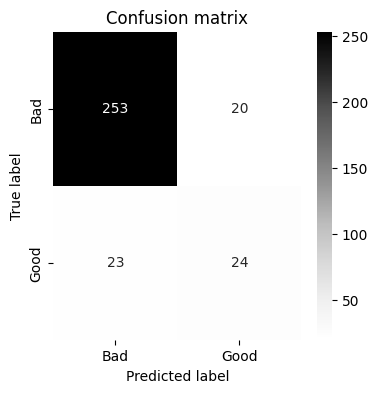

In [29]:
_, y_custom_pred_class = test_model_class(RandomForestClassifierCustom(max_depth=10),
    *train_test_split(x_data, y_class, test_size=0.2, random_state=42)
)

Регрессия:

In [30]:
_ , y_custom_pred_reg = test_model_reg(RandomForestRegressorCustom(max_depth=5),
    *train_test_split(x_data,y_reg,test_size=0.2,random_state=42)
)

LinearRegression:
Mean Absolute Error (MAE): 0.5401488238182485
Root Mean Squared Error (RMSE): 0.6592372219019939
R-squared (R^2): 0.33498115050307986


#### d.	Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2 

In [31]:
print_diff(
    y_test_class, y_custom_pred_class,y_std_pred_class,
    y_test_reg,y_custom_pred_reg,y_std_pred_reg
)

Classification:
Increase between old and new predictions classifier:
Accuracy: -0.034375000000000044
F1-score: -0.07252747252747249

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: 0.11771132381824845
Root Mean Squared Error (RMSE): 0.11038557983466801
R-squared: -0.20406181188428396


#### e.	Сделать выводы

Классификация:

Анализ метрик классификации показывает, что качество работы новой модели ухудшилось:

- Accuracy уменьшилась на -0.034 (3.4%), что свидетельствует о снижении доли правильно классифицированных объектов.
- F1-score снизился на -0.073 (7.3%), что указывает на ухудшение баланса между точностью и полнотой, особенно в условиях несбалансированности классов.

Регрессия:

Для задачи регрессии также наблюдается снижение качества:

- Mean Absolute Error (MAE) увеличилась на 0.118, что говорит об увеличении средней абсолютной ошибки.
- Root Mean Squared Error (RMSE) выросла на 0.110, указывая на более сильные отклонения в предсказаниях.
- R-squared значительно снизился (на -0.204), что указывает на ухудшение способности модели объяснять дисперсию данных.

#### f-h.	Добавить техники из улучшенного бейзлайна (пункт 3с)

Обучить модели (для классификации и регрессии) для выбранных наборов данных

Оценить качество моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

LogisticRegression:
Accuracy: 0.85
F1-score: 0.4782608695652174


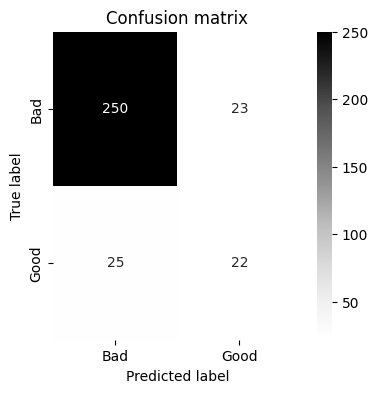

LinearRegression:
Mean Absolute Error (MAE): 0.49636520483606816
Root Mean Squared Error (RMSE): 0.7121339143334096
R-squared (R^2): 0.22397832449606903


In [34]:
wine_data = pd.read_csv('../data/wine_data.csv')
wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)


imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)
x_data_new = x_data.copy()
x_data_new['bound_so2'] = x_data_new['total sulfur dioxide'] - x_data_new['free sulfur dioxide']
x_data_new['other_acidity'] = x_data_new['fixed acidity'] - x_data_new['volatile acidity'] - x_data_new['citric acid']

y_class = wine_data["IsGood"]
y_reg = wine_data["quality"]

x_train, x_test, y_train_class, y_test_class = train_test_split(x_data_new, y_class, test_size=0.2, random_state=42)
x_train, x_test, y_train_reg, y_test_reg = train_test_split(x_data_new, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

_, y_custom_baseline_pred_class = test_model_class(
    RandomForestClassifierCustom(max_depth=20),
    x_train, x_test, y_train_class, y_test_class
)

_, y_custom_baseline_pred_reg = test_model_reg(
    RandomForestRegressorCustom(max_depth=10),
    x_train, x_test, y_train_reg, y_test_reg
)

#### i.	Сравнить результаты моделей в сравнении с результатами из пункта 3

In [35]:
print_diff(
    y_test_class,y_custom_baseline_pred_class,y_baseline_pred_class,
    y_test_reg,y_custom_baseline_pred_reg, y_baseline_pred_reg
)

Classification:
Increase between old and new predictions classifier:
Accuracy: -0.0625
F1-score: -0.17173913043478262

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: 0.07413603816940145
Root Mean Squared Error (RMSE): 0.1587545236799448
R-squared: -0.30742794278228247


#### j.	Сделать выводы

Классификация:

- Точность (Accuracy): Наблюдается снижение точности на 6.25%. Это указывает на то, что кастомная модель менее эффективна в правильной классификации вин по категориям, чем стандартная модель.
- F1-мерa: Снижение F1-меры на 17.17% говорит о том, что кастомная модель значительно хуже справляется с балансом между полнотой и точностью, особенно в условиях несбалансированных классов.

Регрессия:
- Средняя абсолютная ошибка (MAE): Увеличение MAE на 0.0741 указывает на ухудшение точности предсказаний кастомной модели.
- Корень средней квадратичной ошибки (RMSE): Увеличение RMSE на 0.1587 также подтверждает, что кастомная модель хуже справляется с задачей минимизации отклонений.
- Коэффициент детерминации (R²): Значение R² снизилось на 30.74%, что говорит о значительном ухудшении способности модели объяснять вариативность данных.

Кастомные модели для классификации и регрессии показали худшие результаты по сравнению со стандартными. 